# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torch import Tensor
import torchvision
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import copy
from torchvision import datasets

# Load MNIST datasets

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

val_size = 5000
I = np.random.permutation(len(train_set))
val_set = Subset(train_set, I[:val_size])
train_set = Subset(train_set, I[val_size:])

batch_size = 256

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=4)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size, num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=4)


100%|██████████| 9.91M/9.91M [00:28<00:00, 343kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.97MB/s]


# Functions

In [ ]:
def train_epoch(model, train_loader, optimizer, epoch, criterion, device='cpu'):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(train_loader, desc=f'Training epoch {epoch}', leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

In [ ]:
def evaluate(model, train_loader, device='cpu'):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_predictions.append(preds)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    return (accuracy_score(all_labels, all_predictions),
            classification_report(all_labels, all_predictions, zero_division=0, digits=3))

In [ ]:
def plot_validation_curves(losses, accs):

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

In [ ]:
def train(model, epochs, optimizer, train_loader, val_loader, criterion, device='cpu'):
  losses = []
  accs = []

  for epoch in range(epochs):

    loss = train_epoch(model, train_loader, optimizer, epoch, criterion, device=device)
    losses.append(loss)

    (acc, _) = evaluate(model, val_loader, device=device)
    accs.append(acc)

  return losses, accs

# Exercise 1.1: Basic MLP

## Network

In [ ]:
class BasicMLP(nn.Module):
    def __init__(self, input_size=28*28, width=64, output_size=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, width)
        self.fc2 = nn.Linear(width, width)
        self.out = nn.Linear(width, output_size)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

## Training SGD

In [ ]:
seed = 1023
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 50
lr = 0.1
width = 64

model = BasicMLP(input_size=28*28, width=width, output_size=10).to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
criterion = F.cross_entropy

losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 65.76it/s]
                                                           

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.985     0.984     0.984       980
           1      0.989     0.989     0.989      1135
           2      0.974     0.973     0.973      1032
           3      0.970     0.977     0.973      1010
           4      0.975     0.978     0.976       982
           5      0.978     0.969     0.974       892
           6      0.980     0.974     0.977       958
           7      0.983     0.969     0.976      1028
           8      0.972     0.974     0.973       974
           9      0.959     0.977     0.968      1009

    accuracy                          0.977     10000
   macro avg      0.976     0.976     0.976     10000
weighted avg      0.977     0.977     0.977     10000



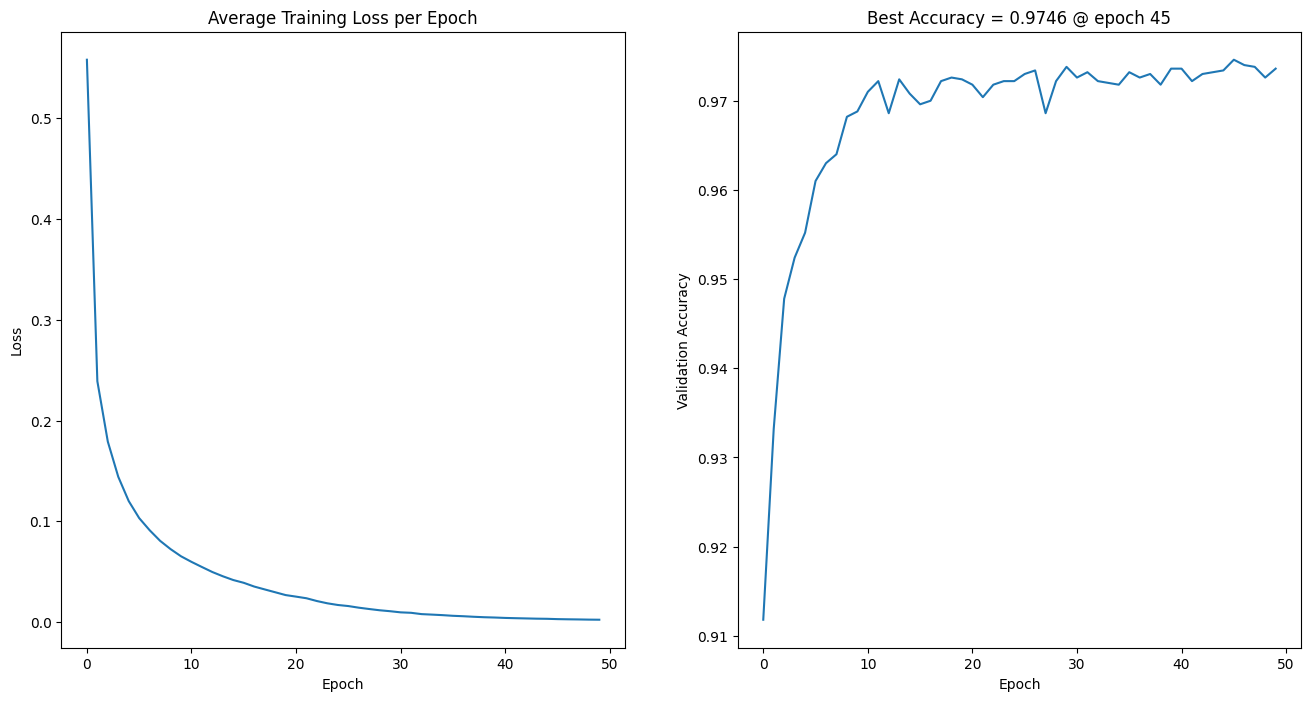

In [ ]:
plot_validation_curves(losses, val_accs)

## Training Adam

In [ ]:
seed = 1023
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 50
lr = 0.001
width = 64

model = BasicMLP(input_size=28*28, width=width, output_size=10).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = F.cross_entropy

losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 63.58it/s]
                                                           

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.979     0.990     0.984       980
           1      0.988     0.989     0.989      1135
           2      0.975     0.980     0.977      1032
           3      0.964     0.979     0.972      1010
           4      0.979     0.979     0.979       982
           5      0.983     0.971     0.977       892
           6      0.982     0.979     0.981       958
           7      0.979     0.973     0.976      1028
           8      0.981     0.967     0.974       974
           9      0.970     0.971     0.971      1009

    accuracy                          0.978     10000
   macro avg      0.978     0.978     0.978     10000
weighted avg      0.978     0.978     0.978     10000



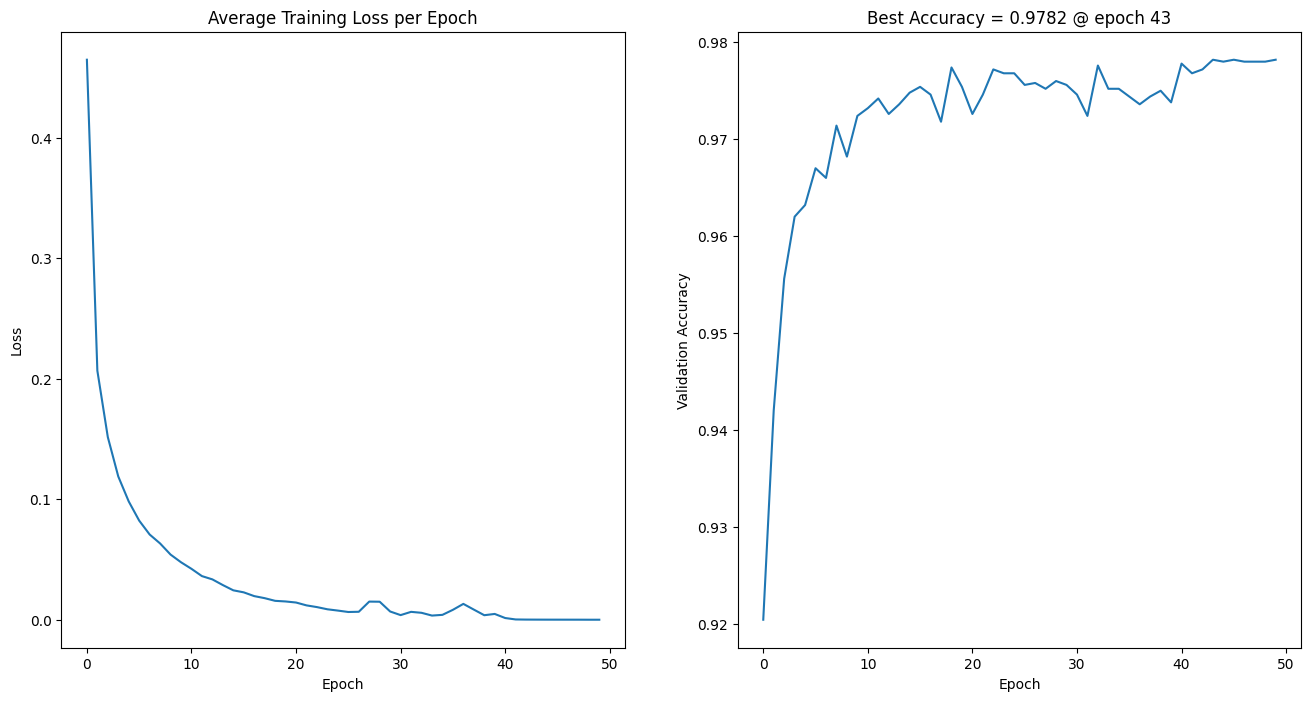

In [ ]:
plot_validation_curves(losses, val_accs)

# Exercise 1.2: MLP depth experiments with and without residual connections

## Network

In [ ]:
class LinearBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc = nn.Linear(width, width)

    def forward(self, x):
        return F.relu(self.fc(x))


class ResMLPBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.network = nn.Sequential(LinearBlock(width), LinearBlock(width))

    def forward(self, x):
        return self.network(x) + x


class Net(nn.Module):
    def __init__(self, input_size=28*28, width=64, depth=1, residual=False, output_size=10):

        super().__init__()

        blocks = [ResMLPBlock(width) if residual else LinearBlock(width) for _ in range(depth)]
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, width),
            nn.ReLU(),
            *blocks,
            nn.Linear(width, output_size)
        )

    def forward(self, x):
        return self.network(x)


## Without residual connections

### Training

#### Depth = 10, 20, 30

Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 65.43it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.980     0.985     0.982       980
           1      0.989     0.989     0.989      1135
           2      0.976     0.977     0.976      1032
           3      0.951     0.990     0.970      1010
           4      0.970     0.973     0.971       982
           5      0.972     0.967     0.970       892
           6      0.985     0.959     0.972       958
           7      0.976     0.969     0.972      1028
           8      0.974     0.946     0.959       974
           9      0.962     0.973     0.967      1009

    accuracy                          0.973     10000
   macro avg      0.973     0.973     0.973     10000
weighted avg      0.973     0.973     0.973     10000



Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 68.06it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.981     0.985     0.983       980
           1      0.990     0.978     0.984      1135
           2      0.966     0.965     0.966      1032
           3      0.942     0.950     0.946      1010
           4      0.969     0.965     0.967       982
           5      0.945     0.961     0.953       892
           6      0.955     0.972     0.963       958
           7      0.982     0.963     0.972      1028
           8      0.927     0.951     0.939       974
           9      0.970     0.941     0.955      1009

    accuracy                          0.963     10000
   macro avg      0.963     0.963     0.963     10000
weighted avg      0.963     0.963     0.963     10000



Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 69.38it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       980
           1      0.114     1.000     0.204      1135
           2      0.000     0.000     0.000      1032
           3      0.000     0.000     0.000      1010
           4      0.000     0.000     0.000       982
           5      0.000     0.000     0.000       892
           6      0.000     0.000     0.000       958
           7      0.000     0.000     0.000      1028
           8      0.000     0.000     0.000       974
           9      0.000     0.000     0.000      1009

    accuracy                          0.114     10000
   macro avg      0.011     0.100     0.020     10000
weighted avg      0.013     0.114     0.023     10000



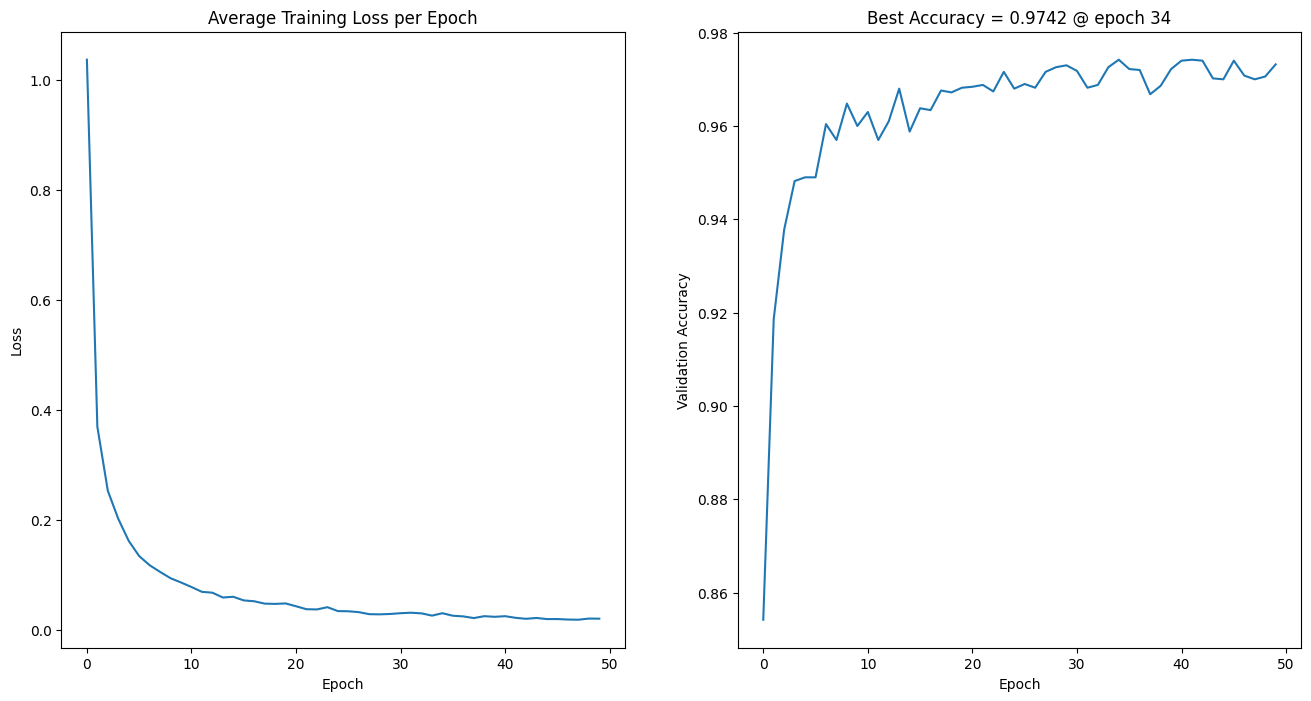

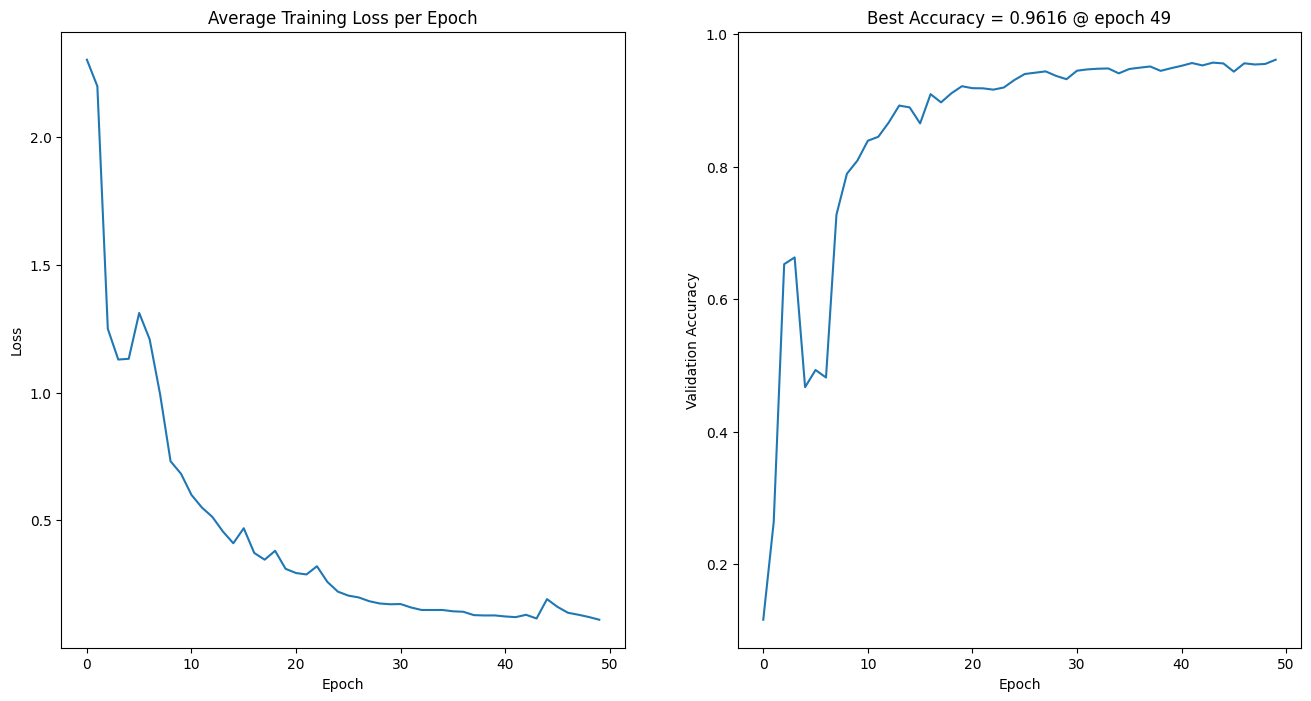

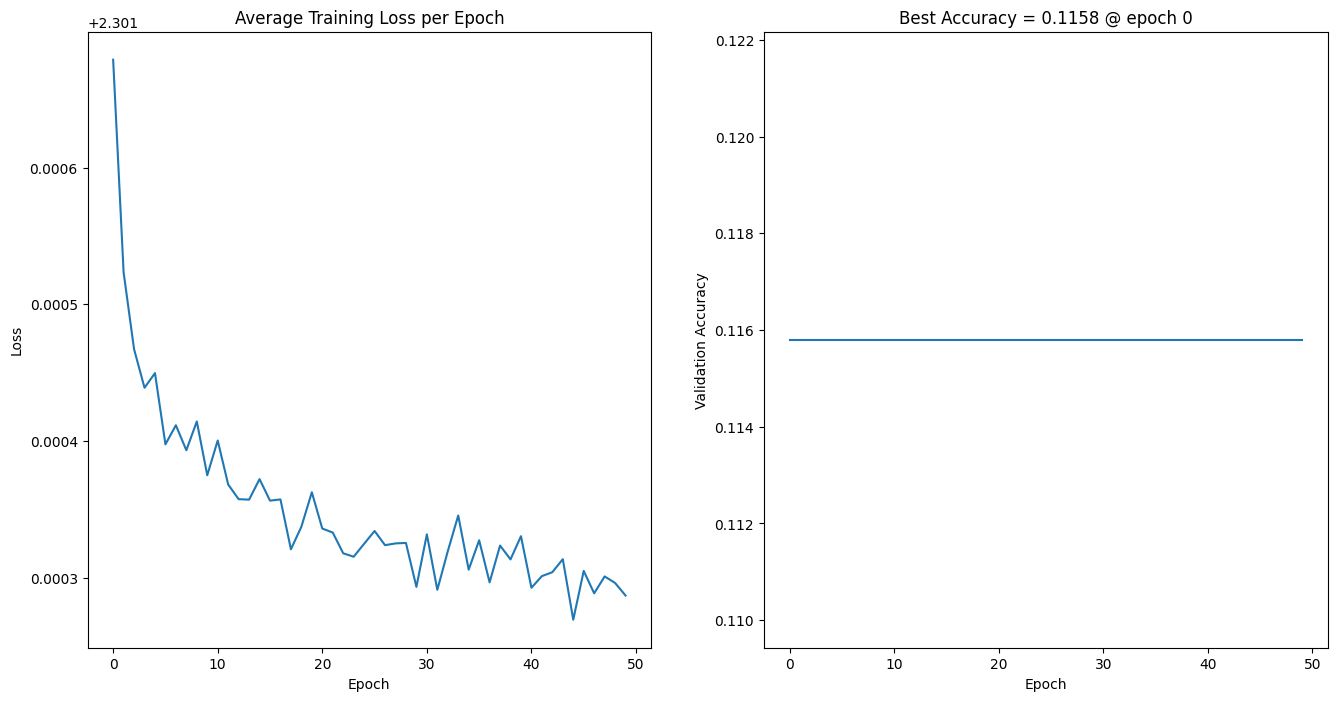

In [ ]:
seed = 1023
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs =50
lr = 0.001
width = 64

for depth in [10, 20, 30]:

  model = Net(input_size=28*28, width=width, depth=depth, residual=False, output_size=10).to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  criterion = F.cross_entropy

  losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

  plot_validation_curves(losses, val_accs)

  print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

### Gradients exploration

In [ ]:
def analyse_gradients(model):

  biases = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 1]

  weights = [p.grad.detach().cpu() for p in model.parameters() if p.dim() == 2]

  plt.plot([(p * p).sum().sqrt().item() for p in biases])
  plt.plot([(p * p).sum().sqrt().item() for p in weights])
  plt.xlabel('Layer')
  plt.ylabel('$||\\nabla_p \\mathcal{L}||$')
  plt.legend(['Biases', 'Weight Matrices'])
  plt.title('Residual Gradient Norm Analysis')

Text(0.5, 1.0, 'Residual Gradient Norm Analysis')

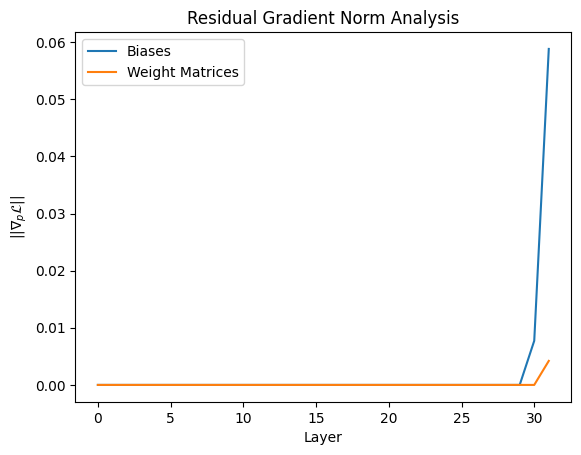

In [ ]:
analyse_gradients(model)

## With residual connections

### Training

Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 69.69it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.993     0.961     0.977       980
           1      0.993     0.989     0.991      1135
           2      0.981     0.981     0.981      1032
           3      0.964     0.975     0.969      1010
           4      0.972     0.976     0.974       982
           5      0.974     0.979     0.977       892
           6      0.986     0.978     0.982       958
           7      0.961     0.982     0.971      1028
           8      0.985     0.958     0.971       974
           9      0.956     0.982     0.969      1009

    accuracy                          0.976     10000
   macro avg      0.976     0.976     0.976     10000
weighted avg      0.976     0.976     0.976     10000



Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 68.71it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.990     0.989     0.989       980
           1      0.985     0.992     0.989      1135
           2      0.984     0.982     0.983      1032
           3      0.976     0.978     0.977      1010
           4      0.979     0.979     0.979       982
           5      0.976     0.976     0.976       892
           6      0.978     0.984     0.981       958
           7      0.988     0.965     0.976      1028
           8      0.968     0.977     0.973       974
           9      0.967     0.970     0.969      1009

    accuracy                          0.979     10000
   macro avg      0.979     0.979     0.979     10000
weighted avg      0.979     0.979     0.979     10000



Training epoch 49: 100%|██████████| 215/215 [00:03<00:00, 62.65it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.990     0.989     0.989       980
           1      0.993     0.987     0.990      1135
           2      0.972     0.973     0.972      1032
           3      0.967     0.977     0.972      1010
           4      0.986     0.978     0.982       982
           5      0.990     0.961     0.975       892
           6      0.992     0.979     0.985       958
           7      0.966     0.977     0.971      1028
           8      0.960     0.985     0.972       974
           9      0.973     0.979     0.976      1009

    accuracy                          0.979     10000
   macro avg      0.979     0.978     0.979     10000
weighted avg      0.979     0.979     0.979     10000



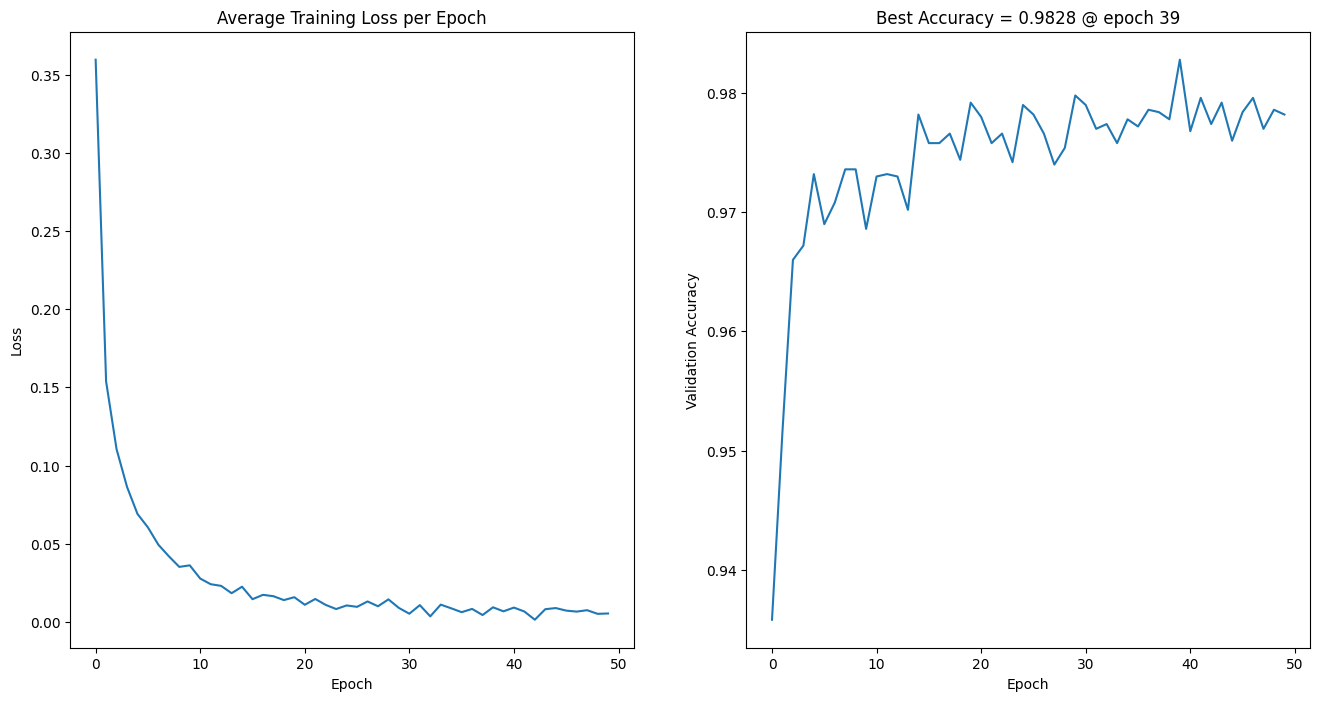

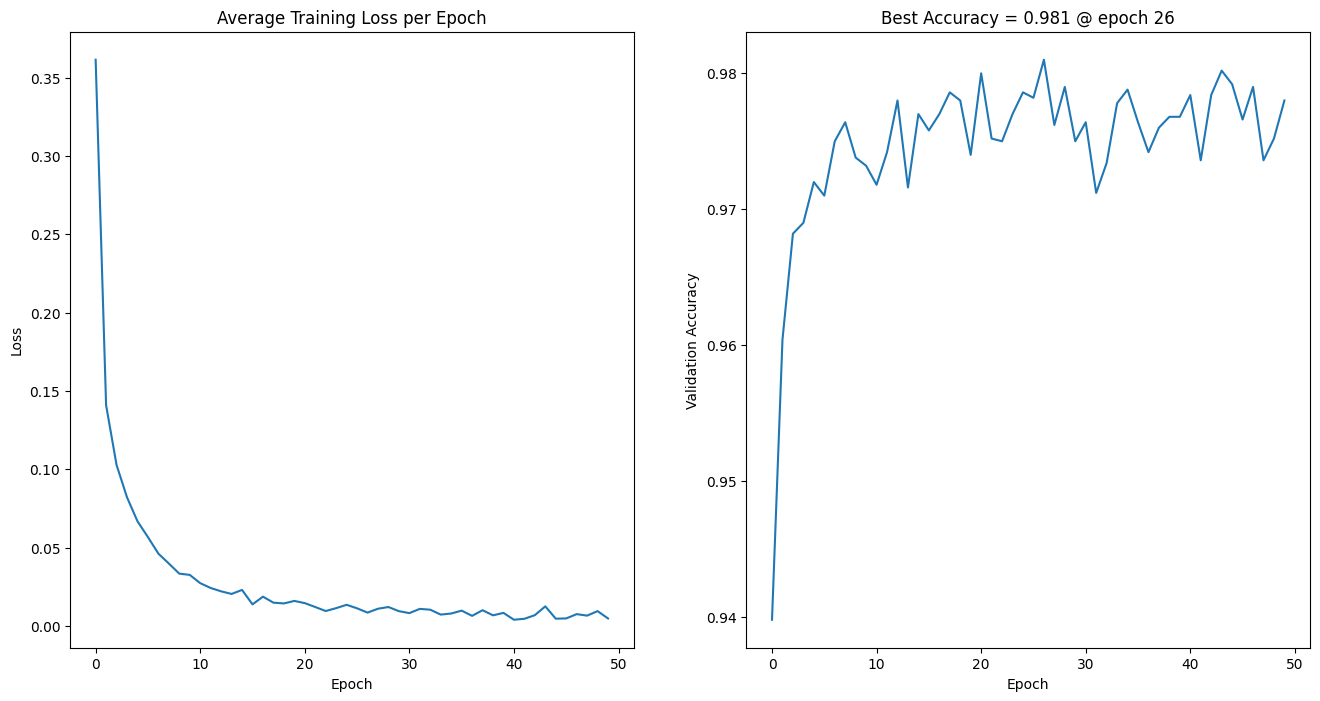

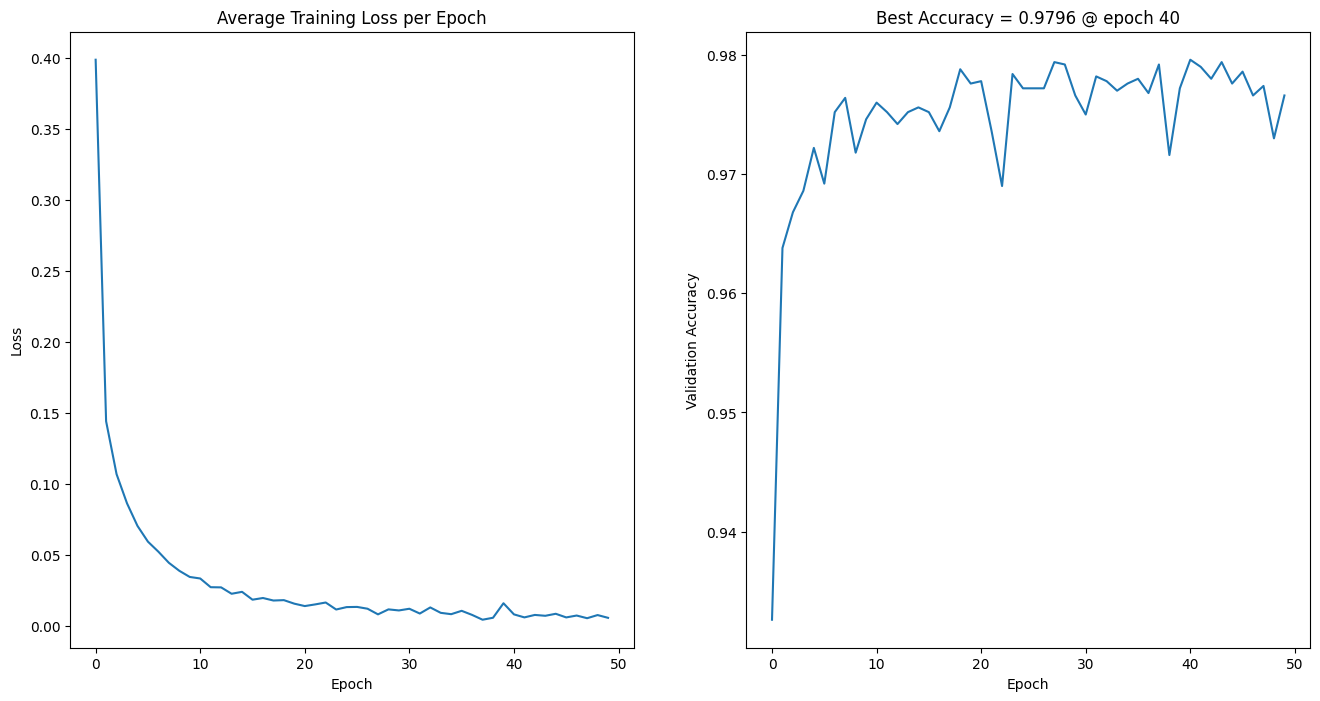

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 50
lr = 0.001

seed = 1023
torch.manual_seed(seed)

width = 64

for depth in [5, 10, 15]:

  model = Net(input_size=28*28, width=width, depth=depth, residual=True, output_size=10).to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  criterion = F.cross_entropy

  losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

  plot_validation_curves(losses, val_accs)

  print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

### Gradients exploration

Text(0.5, 1.0, 'Residual Gradient Norm Analysis')

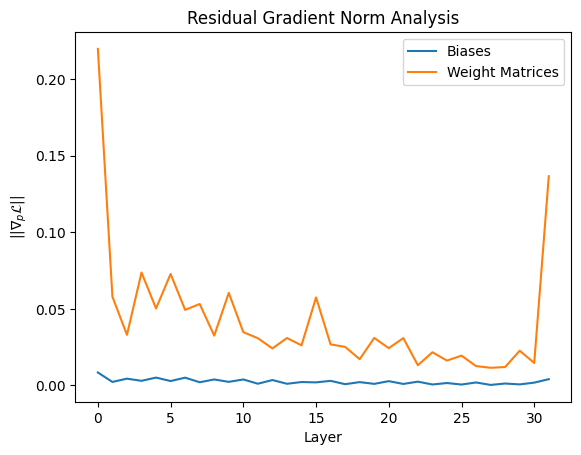

In [ ]:
analyse_gradients(model)

# Exercise 1.3: CNNs with and without residual connections

## Load Cifar10 dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 64

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=False)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                          drop_last=False)


100%|██████████| 170M/170M [00:04<00:00, 40.0MB/s]


## Network

In [ ]:
class LinearBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc = nn.Linear(width, width)

    def forward(self, x):
        return F.relu(self.fc(x))


class ResMLPBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.network = nn.Sequential(LinearBlock(width), LinearBlock(width))

    def forward(self, x):
        return self.network(x) + x


class BasicConvBlock(nn.Module):
    def __init__(self, inplanes: int, planes: int, stride: int = 1, residual: bool = True):
        super().__init__()
        self.residual = residual

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.residual:
            out += identity
        out = self.relu(out)
        return out


class Net(nn.Module):
    def __init__(self, mode='mlp', input_size=28*28, in_channels=1, width=64, base_channels=64,
                 depth=1, residual=False, output_size=10):
        super().__init__()
        self.mode = mode

        if mode == 'mlp':
            blocks = [ResMLPBlock(width) if residual else LinearBlock(width) for _ in range(depth)]
            self.network = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, width),
                nn.ReLU(),
                *blocks,
                nn.Linear(width, output_size)
            )
        elif mode == 'cnn':
            blocks = [BasicConvBlock(base_channels, base_channels, residual=residual) for _ in range(depth)]
            self.network = nn.Sequential(
                nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(base_channels),
                nn.ReLU(inplace=True),
                *blocks,
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Linear(base_channels, output_size)
            )
        else:
            raise ValueError("Mode must be either 'mlp' or 'cnn'")

    def forward(self, x):
        return self.network(x)


## With residual connections

Training epoch 99: 100%|██████████| 625/625 [00:19<00:00, 31.42it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.876     0.858     0.867      1000
           1      0.989     0.810     0.891      1000
           2      0.776     0.838     0.806      1000
           3      0.731     0.773     0.751      1000
           4      0.865     0.853     0.859      1000
           5      0.762     0.824     0.792      1000
           6      0.888     0.892     0.890      1000
           7      0.956     0.786     0.863      1000
           8      0.901     0.932     0.916      1000
           9      0.838     0.951     0.891      1000

    accuracy                          0.852     10000
   macro avg      0.858     0.852     0.853     10000
weighted avg      0.858     0.852     0.853     10000



Training epoch 99: 100%|██████████| 625/625 [00:38<00:00, 16.38it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.903     0.852     0.877      1000
           1      0.925     0.942     0.934      1000
           2      0.785     0.852     0.817      1000
           3      0.805     0.728     0.765      1000
           4      0.891     0.861     0.876      1000
           5      0.743     0.862     0.798      1000
           6      0.881     0.904     0.892      1000
           7      0.949     0.837     0.889      1000
           8      0.892     0.947     0.919      1000
           9      0.935     0.892     0.913      1000

    accuracy                          0.868     10000
   macro avg      0.871     0.868     0.868     10000
weighted avg      0.871     0.868     0.868     10000



Training epoch 99: 100%|██████████| 625/625 [00:56<00:00, 11.10it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.903     0.865     0.884      1000
           1      0.945     0.946     0.946      1000
           2      0.786     0.861     0.822      1000
           3      0.804     0.742     0.772      1000
           4      0.789     0.940     0.858      1000
           5      0.874     0.754     0.809      1000
           6      0.910     0.907     0.908      1000
           7      0.899     0.899     0.899      1000
           8      0.936     0.937     0.937      1000
           9      0.939     0.911     0.925      1000

    accuracy                          0.876     10000
   macro avg      0.878     0.876     0.876     10000
weighted avg      0.878     0.876     0.876     10000



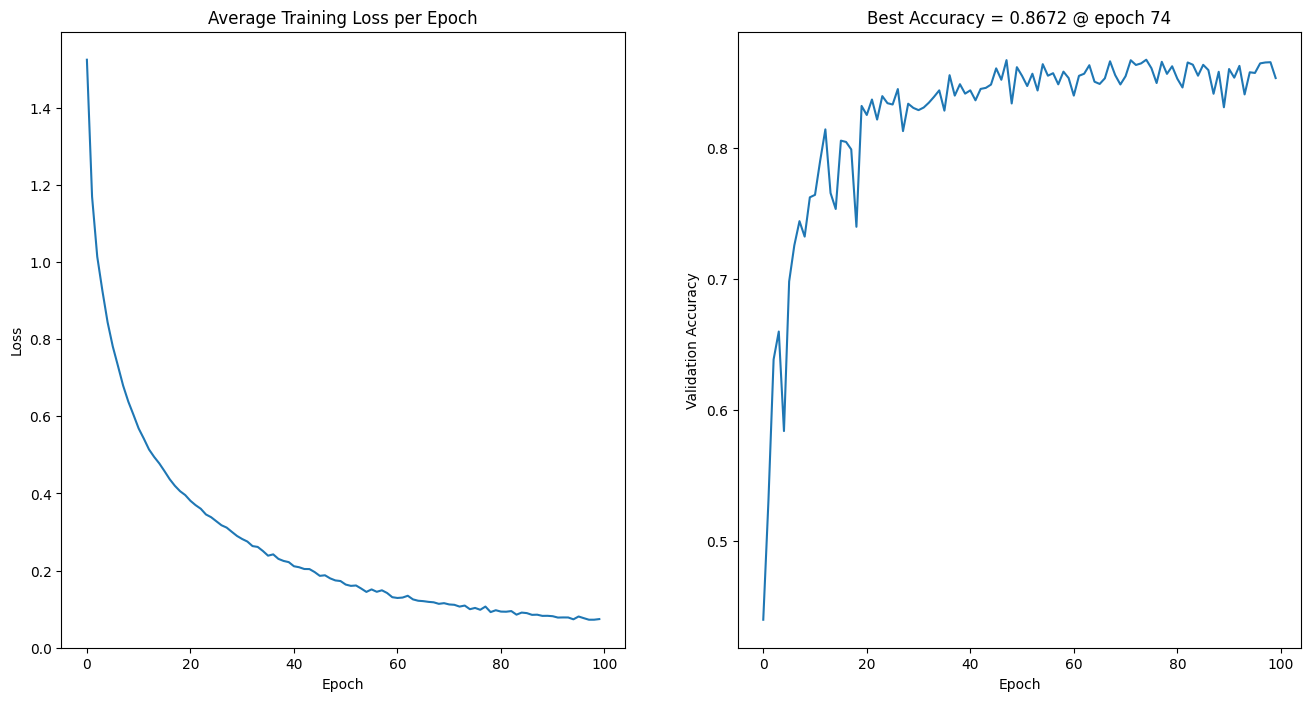

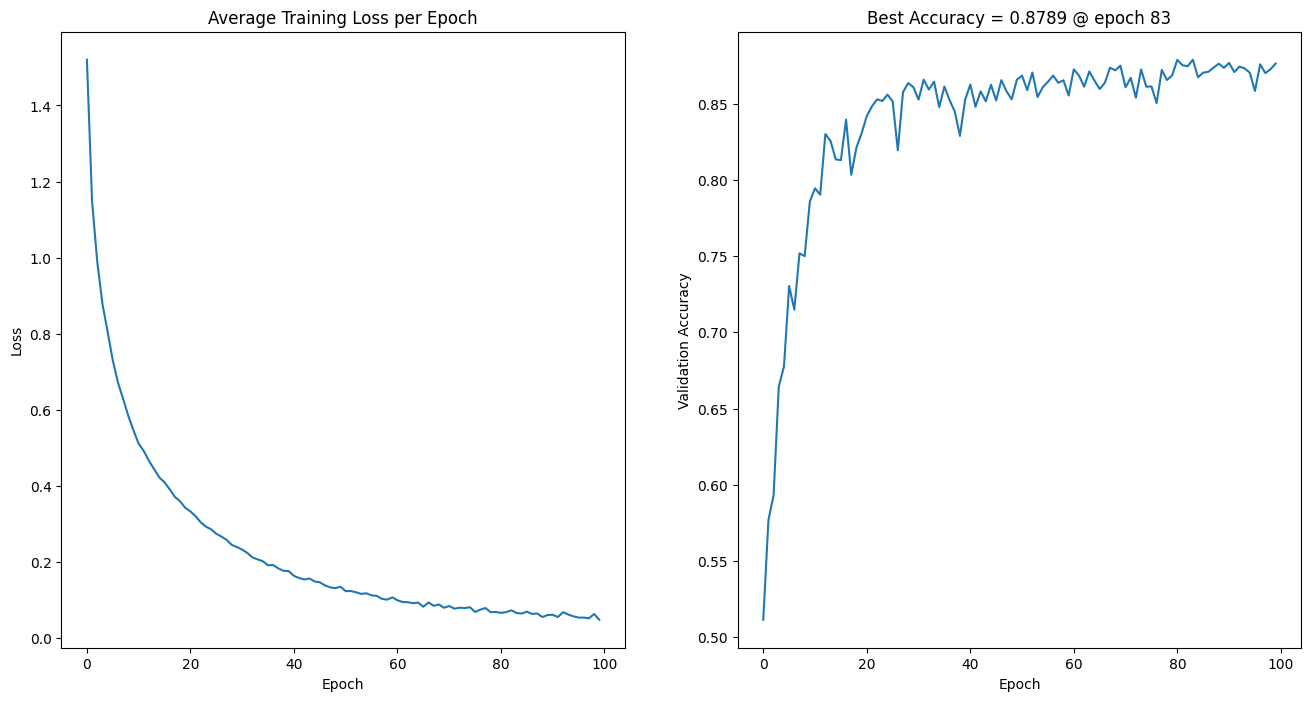

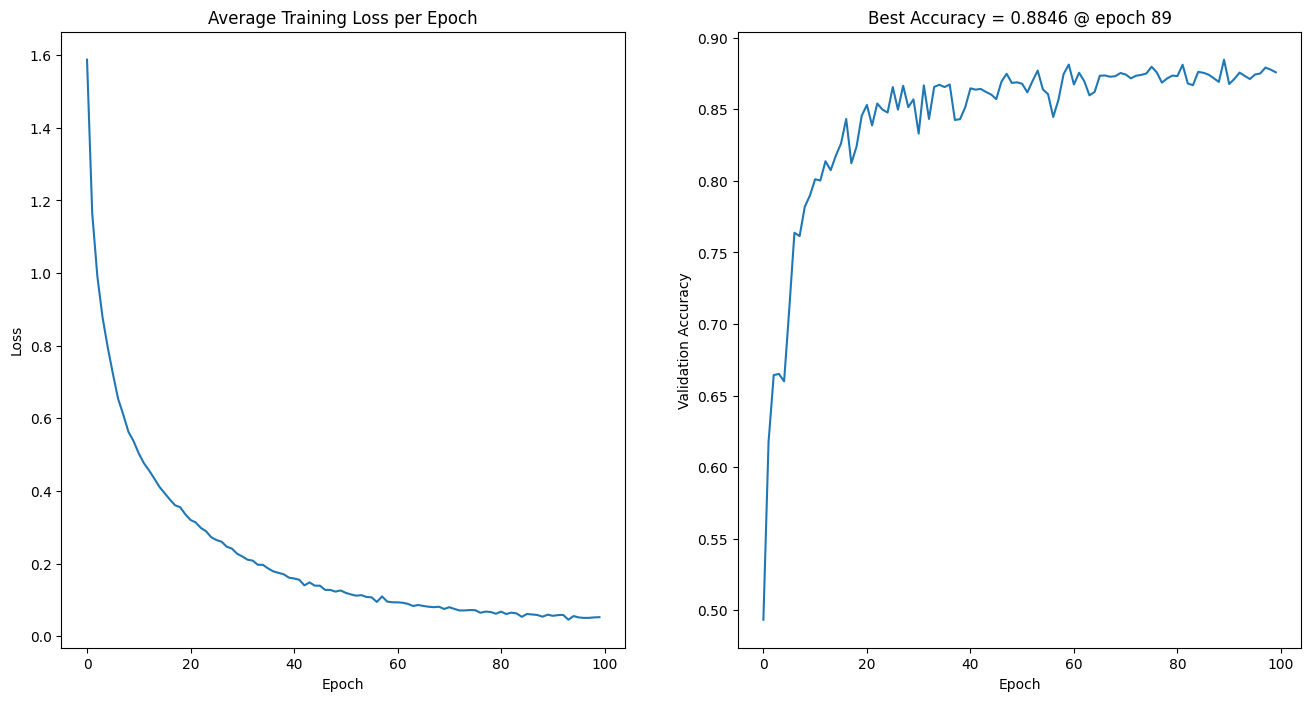

In [ ]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)

for depth in [5, 10, 15]:

  model = Net(mode='cnn', in_channels=3, base_channels=64, depth=depth, residual=True, output_size=10).to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  criterion = F.cross_entropy

  losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

  plot_validation_curves(losses, val_accs)

  print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

## Without residual connections

Training epoch 99: 100%|██████████| 625/625 [00:19<00:00, 32.69it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.872     0.836     0.853      1000
           1      0.910     0.940     0.925      1000
           2      0.701     0.873     0.778      1000
           3      0.876     0.587     0.703      1000
           4      0.891     0.800     0.843      1000
           5      0.770     0.839     0.803      1000
           6      0.885     0.889     0.887      1000
           7      0.879     0.905     0.892      1000
           8      0.890     0.919     0.904      1000
           9      0.889     0.923     0.906      1000

    accuracy                          0.851     10000
   macro avg      0.856     0.851     0.849     10000
weighted avg      0.856     0.851     0.849     10000



Training epoch 99: 100%|██████████| 625/625 [00:36<00:00, 17.05it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.834     0.847     0.841      1000
           1      0.905     0.929     0.917      1000
           2      0.803     0.755     0.778      1000
           3      0.776     0.666     0.717      1000
           4      0.795     0.870     0.831      1000
           5      0.746     0.806     0.775      1000
           6      0.807     0.924     0.862      1000
           7      0.844     0.842     0.843      1000
           8      0.941     0.869     0.904      1000
           9      0.929     0.854     0.890      1000

    accuracy                          0.836     10000
   macro avg      0.838     0.836     0.836     10000
weighted avg      0.838     0.836     0.836     10000



Training epoch 99: 100%|██████████| 625/625 [00:54<00:00, 11.55it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.829     0.796     0.812      1000
           1      0.923     0.881     0.902      1000
           2      0.774     0.785     0.780      1000
           3      0.729     0.730     0.729      1000
           4      0.871     0.774     0.819      1000
           5      0.780     0.783     0.781      1000
           6      0.888     0.839     0.863      1000
           7      0.849     0.871     0.860      1000
           8      0.860     0.909     0.884      1000
           9      0.809     0.930     0.866      1000

    accuracy                          0.830     10000
   macro avg      0.831     0.830     0.830     10000
weighted avg      0.831     0.830     0.830     10000



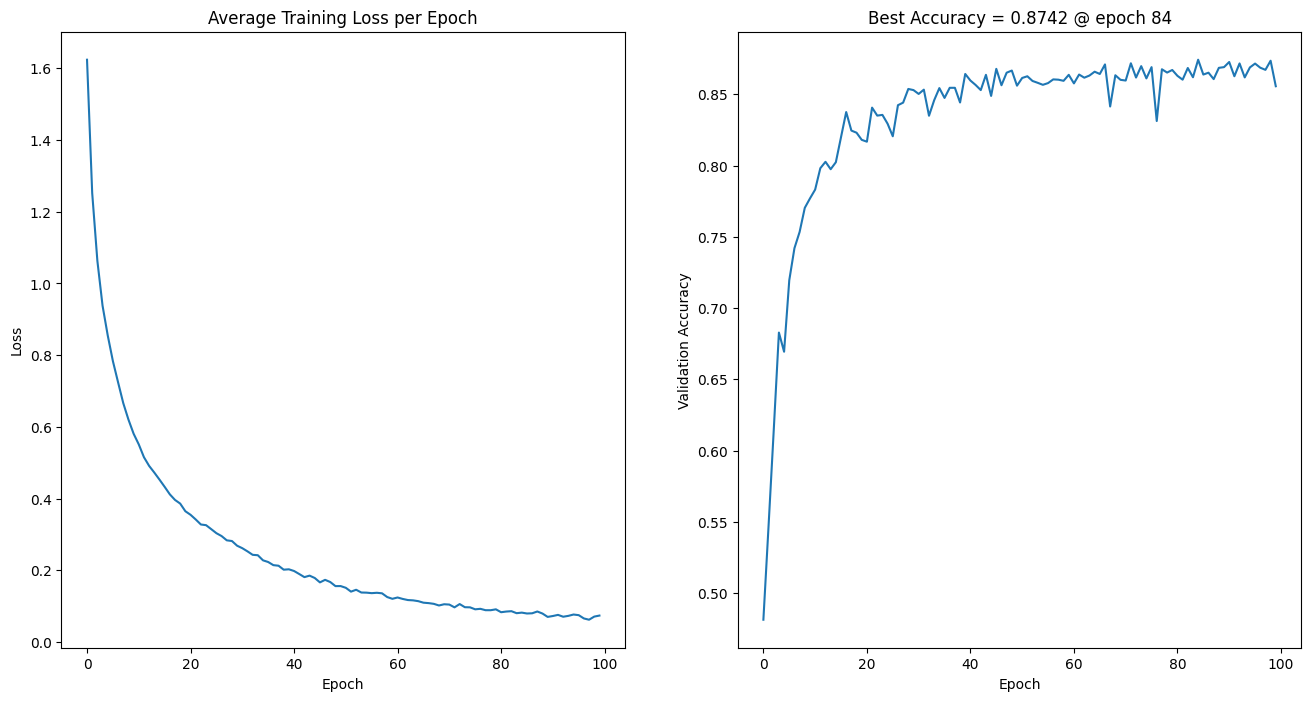

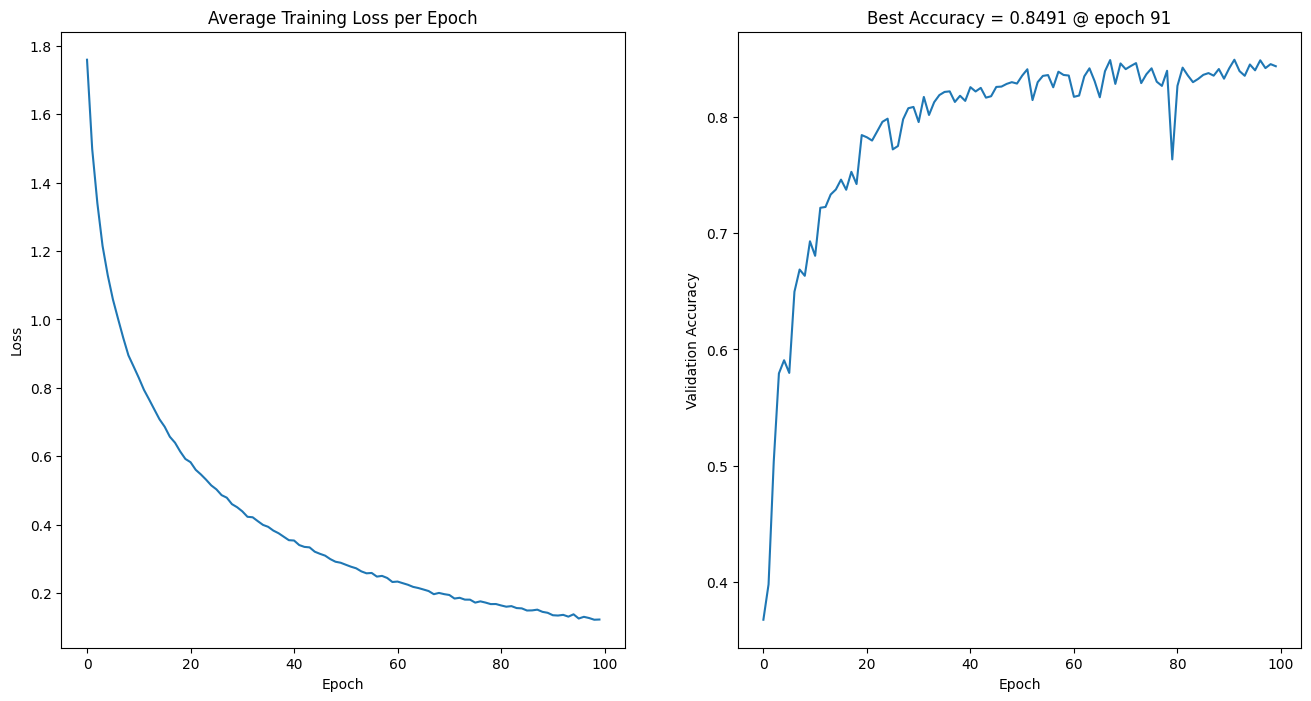

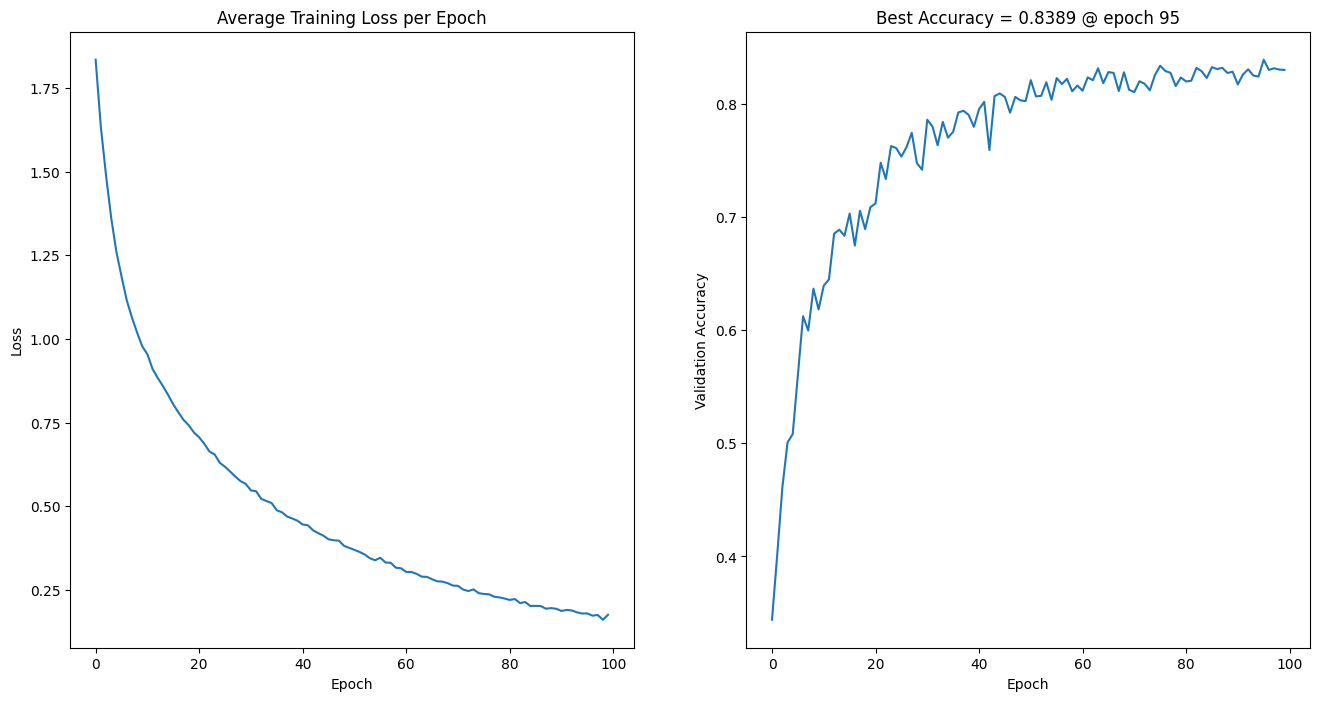

In [ ]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)

for depth in [5, 10, 15]:

  model = Net(mode='cnn', in_channels=3, base_channels=64, depth=depth, residual=False, output_size=10).to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
  criterion = F.cross_entropy

  losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

  plot_validation_curves(losses, val_accs)

  print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

# Exercise 2.1: Fine-tune of a pre-trained CNN

## Network

In [ ]:
class Net(nn.Module):
    def __init__(self, mode='mlp', input_size=28*28, in_channels=1, width=64, base_channels=64,
                 depth=1, residual=False, output_size=10, return_features=False):
        super().__init__()
        self.mode = mode
        self.return_features = return_features

        if mode == 'mlp':
            blocks = [ResMLPBlock(width) if residual else LinearBlock(width) for _ in range(depth)]
            self.feature_extractor = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, width),
                nn.ReLU(),
                *blocks
            )
            self.classifier = nn.Linear(width, output_size)

        elif mode == 'cnn':
            blocks = [BasicConvBlock(base_channels, base_channels, residual=residual) for _ in range(depth)]
            self.feature_extractor = nn.Sequential(
                nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(base_channels),
                nn.ReLU(inplace=True),
                *blocks,
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten()
            )
            self.fc = nn.Linear(base_channels, base_channels)
            self.classifier = nn.Linear(base_channels, output_size)
        else:
            raise ValueError("Mode must be either 'mlp' or 'cnn'")

    def forward(self, x):
        features = self.feature_extractor(x)
        if self.return_features:
            return features
        return self.classifier(features)

    def get_features(self, x):
        return self.feature_extractor(x)


## Load Cifar10 dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 64

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=False)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                          drop_last=False)


100%|██████████| 170M/170M [00:19<00:00, 8.74MB/s]


## Training

Training epoch 99: 100%|██████████| 625/625 [00:19<00:00, 31.95it/s]


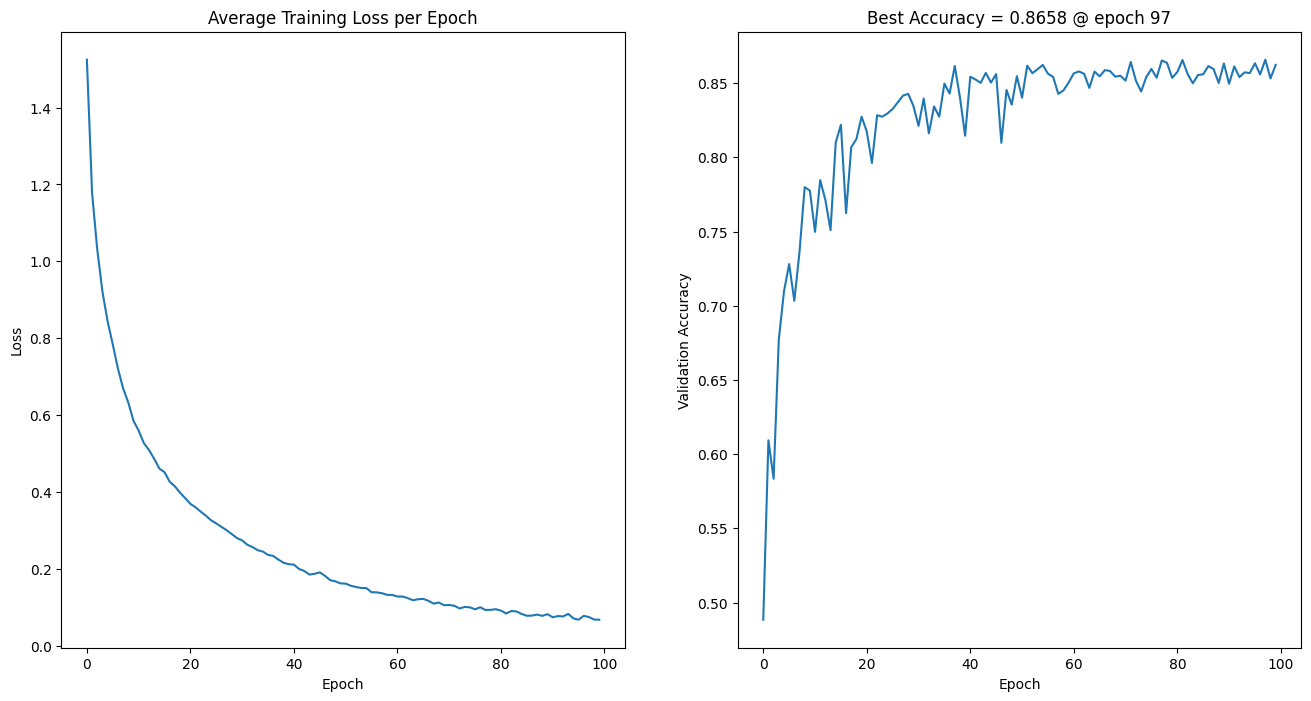

In [ ]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)
depth = 5

model = Net(mode='cnn', in_channels=3, base_channels=64, residual=True, depth=depth, output_size=10).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = F.cross_entropy

losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

plot_validation_curves(losses, val_accs)

In [ ]:
print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.819     0.917     0.865      1000
           1      0.881     0.958     0.918      1000
           2      0.791     0.850     0.819      1000
           3      0.810     0.714     0.759      1000
           4      0.841     0.872     0.856      1000
           5      0.821     0.797     0.809      1000
           6      0.920     0.870     0.894      1000
           7      0.892     0.881     0.886      1000
           8      0.931     0.915     0.923      1000
           9      0.935     0.851     0.891      1000

    accuracy                          0.863     10000
   macro avg      0.864     0.863     0.862     10000
weighted avg      0.864     0.863     0.862     10000



## Load Cifar100

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
test_set = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader_100 = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader_100 = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
test_loader_100 = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4)


100%|██████████| 169M/169M [00:12<00:00, 13.1MB/s]


## Extract features

In [ ]:
def extract_features(model, data_loader, device):
  model.return_features = True
  model.eval()

  features = []
  labels = []
  with torch.no_grad():
    for x_batch, y_batch in data_loader:
      feats = model(x_batch.to(device))
      features.append(feats.cpu().numpy())
      labels.append(y_batch.numpy())

  features = np.concatenate(features)
  labels = np.concatenate(labels)

  return features, labels

In [ ]:
train_features, train_labels = extract_features(model, train_loader_100, device)
val_features, val_labels = extract_features(model, val_loader_100, device)

## Train a classical classifier

#### Linear SVM

In [ ]:
lsvc = LinearSVC()
lsvc.fit(train_features, train_labels)

LinearSVC()

In [ ]:
preds = lsvc.predict(val_features)
accuracy = accuracy_score(val_labels, preds)
print("CIFAR-100 accuracy (SVM baseline):", accuracy)

CIFAR-100 accuracy (SVM baseline): 0.3024


#### K-Nearest Neighbor

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels)

KNeighborsClassifier()

In [ ]:
val_preds = knn.predict(val_features)
accuracy = accuracy_score(val_labels, val_preds)
print("CIFAR-100 accuracy (KNN baseline):", accuracy)

CIFAR-100 accuracy (KNN baseline): 0.1611


## Fine-Tune on CIFAR-100

### Replace Final Classifier

In [ ]:
model.return_features = False
model.classifier = nn.Linear(model.classifier.in_features, 100)  # from 10 to 100
model.to(device)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): BasicConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Identity()
    )
    (4): BasicConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 

In [ ]:
model_copy = copy.deepcopy(model)

### Freeze Feature Extractor

In [ ]:
for param in model.feature_extractor.parameters():
    param.requires_grad = False

In [ ]:
seed = 1023
torch.manual_seed(seed)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = F.cross_entropy

epochs = 100
losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

Training epoch 99: 100%|██████████| 313/313 [00:04<00:00, 69.17it/s]


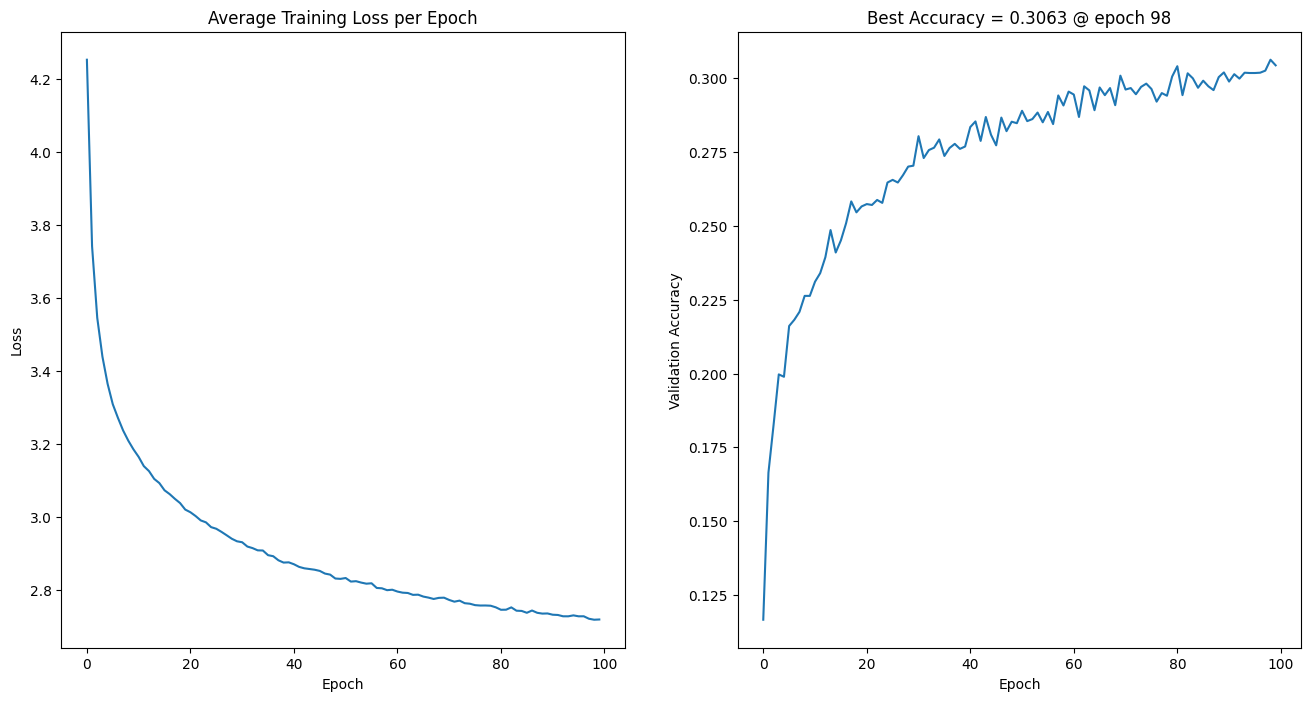

In [ ]:
plot_validation_curves(losses, val_accs)

In [ ]:
print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.463     0.440     0.451       100
           1      0.342     0.270     0.302       100
           2      0.207     0.180     0.193       100
           3      0.185     0.100     0.130       100
           4      0.154     0.080     0.105       100
           5      0.280     0.140     0.187       100
           6      0.126     0.150     0.137       100
           7      0.176     0.120     0.143       100
           8      0.539     0.410     0.466       100
           9      0.420     0.470     0.443       100
          10      0.271     0.130     0.176       100
          11      0.107     0.130     0.117       100
          12      0.426     0.490     0.456       100
          13      0.358     0.380     0.369       100
          14      0.180     0.160     0.169       100
          15      0.260     0.250     0.255       100
          16      0.336     0.370     0.352       100
 

### Unfreeze feature extractor

#### Adam optimizer

In [ ]:
fe_params = {'params': model.feature_extractor.parameters(), 'lr': 0.001}
fc_params = {'params': model.fc.parameters(), 'lr': 0.001}
clf_params = {'params': model.classifier.parameters(), 'lr': 0.001}

optimizer = torch.optim.Adam([fe_params, fc_params, clf_params])
criterion = F.cross_entropy

In [ ]:
seed = 1023
torch.manual_seed(seed)

epochs = 100
losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

Training epoch 99: 100%|██████████| 313/313 [00:15<00:00, 20.71it/s]


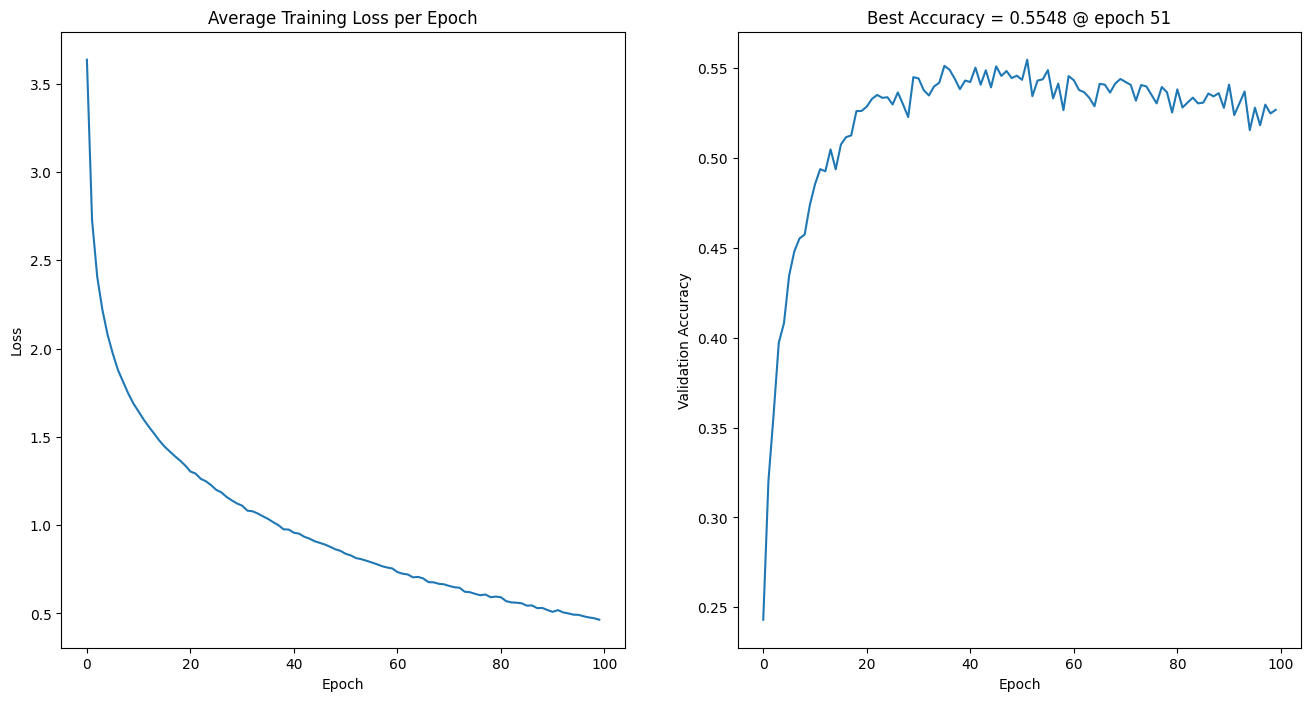

In [ ]:
plot_validation_curves(losses, val_accs)

In [ ]:
print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.864     0.760     0.809       100
           1      0.654     0.680     0.667       100
           2      0.440     0.370     0.402       100
           3      0.425     0.450     0.437       100
           4      0.436     0.480     0.457       100
           5      0.496     0.560     0.526       100
           6      0.690     0.490     0.573       100
           7      0.795     0.310     0.446       100
           8      0.904     0.750     0.820       100
           9      0.661     0.720     0.689       100
          10      0.402     0.430     0.415       100
          11      0.423     0.330     0.371       100
          12      0.537     0.580     0.558       100
          13      0.506     0.430     0.465       100
          14      0.372     0.510     0.430       100
          15      0.541     0.530     0.535       100
          16      0.541     0.660     0.595       100
 

#### SGD optimizer

In [ ]:
fe_params = {'params': model_copy.feature_extractor.parameters(), 'lr': 0.01}
fc_params = {'params': model_copy.fc.parameters(), 'lr': 0.01}
clf_params = {'params': model_copy.classifier.parameters(), 'lr': 0.01}

optimizer = torch.optim.SGD([fe_params, fc_params, clf_params], momentum=0.9)
criterion = F.cross_entropy

In [ ]:
seed = 1023
torch.manual_seed(seed)

epochs = 100
losses, val_accs = train(model_copy, epochs, optimizer, train_loader, val_loader, criterion, device=device)

Training epoch 99: 100%|██████████| 313/313 [00:14<00:00, 21.02it/s]


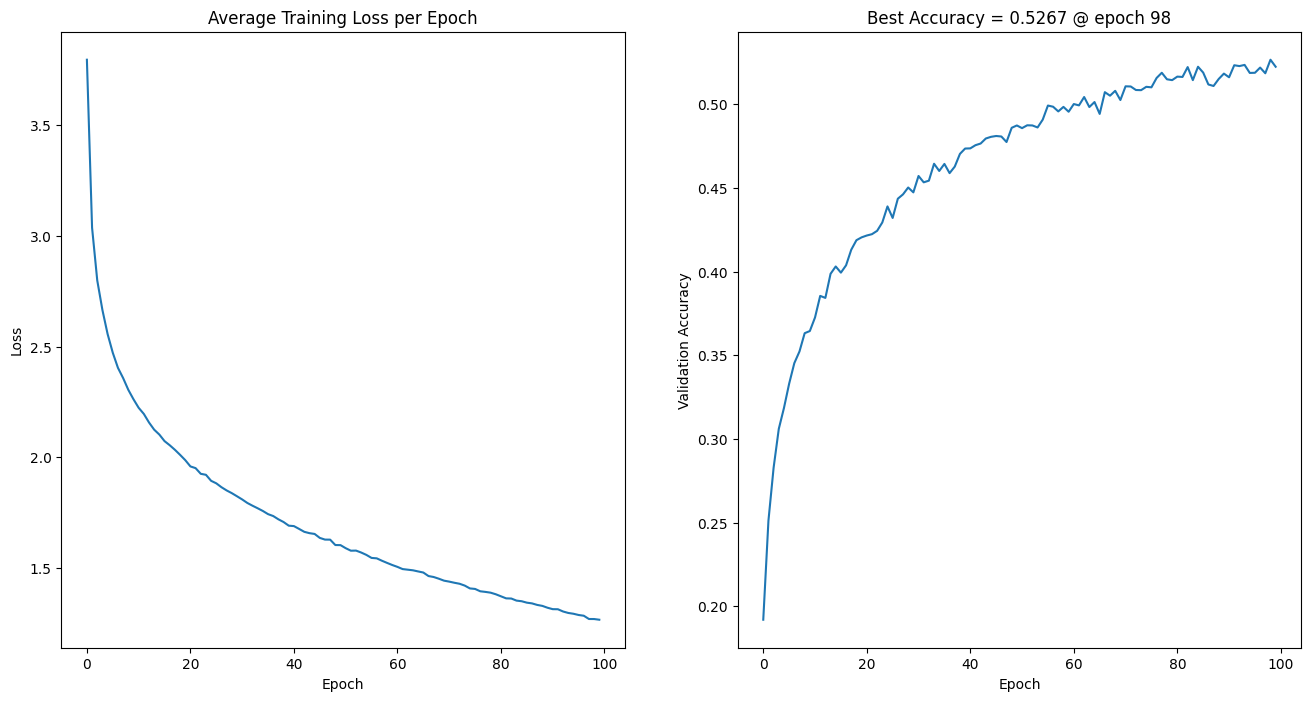

In [ ]:
plot_validation_curves(losses, val_accs)

In [ ]:
print(f'Accuracy report on TEST:\n {evaluate(model_copy, test_loader, device=device)[1]}')

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.910     0.710     0.798       100
           1      0.687     0.570     0.623       100
           2      0.322     0.560     0.409       100
           3      0.276     0.350     0.308       100
           4      0.359     0.140     0.201       100
           5      0.589     0.430     0.497       100
           6      0.553     0.470     0.508       100
           7      0.386     0.510     0.440       100
           8      0.748     0.770     0.759       100
           9      0.545     0.660     0.597       100
          10      0.427     0.320     0.366       100
          11      0.500     0.230     0.315       100
          12      0.533     0.650     0.586       100
          13      0.467     0.490     0.478       100
          14      0.333     0.470     0.390       100
          15      0.400     0.520     0.452       100
          16      0.712     0.470     0.566       100
 

### Model training on Cifar100

#### Load Cifar100 dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
test_set = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4)


#### Training

Training epoch 99: 100%|██████████| 313/313 [00:14<00:00, 20.99it/s]


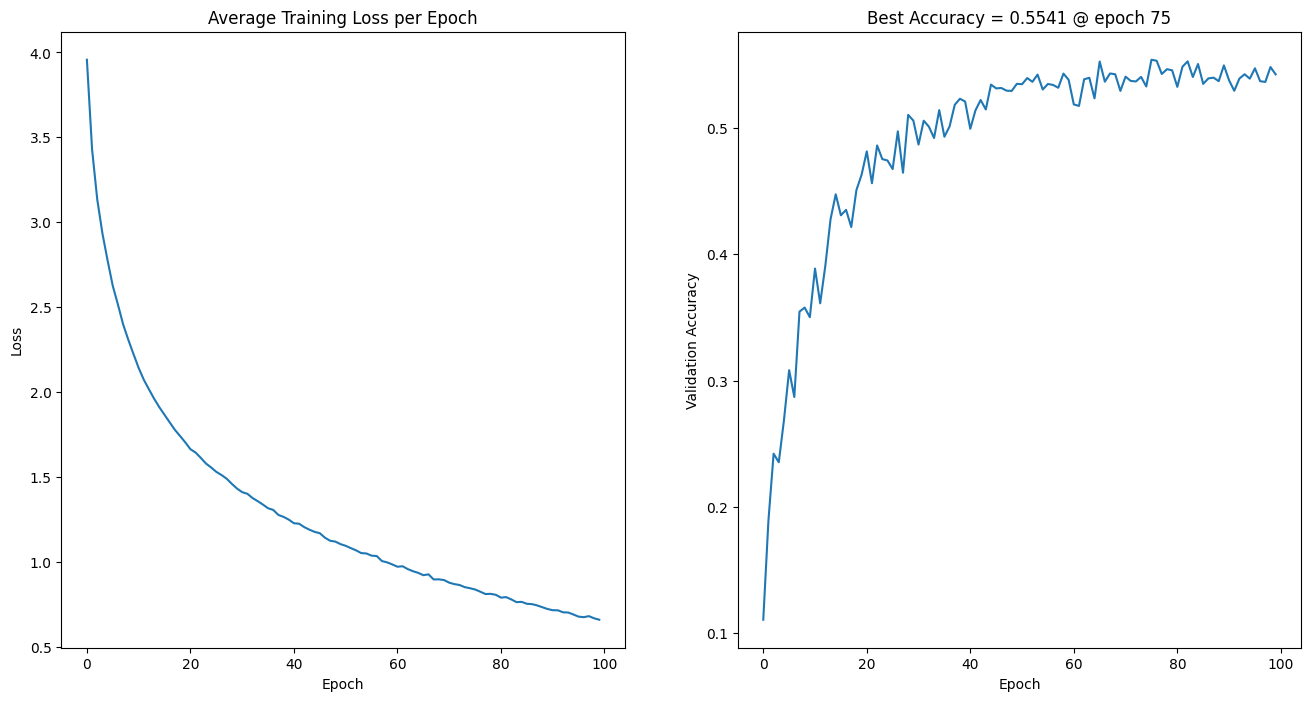

In [ ]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)
depth = 5

model = Net(mode='cnn', in_channels=3, base_channels=64, residual=True, depth=depth, output_size=100).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = F.cross_entropy

losses, val_accs = train(model, epochs, optimizer, train_loader, val_loader, criterion, device=device)

plot_validation_curves(losses, val_accs)

In [ ]:
print(f'Accuracy report on TEST:\n {evaluate(model, test_loader, device=device)[1]}')

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.769     0.830     0.798       100
           1      0.663     0.650     0.657       100
           2      0.509     0.560     0.533       100
           3      0.648     0.350     0.455       100
           4      0.483     0.290     0.362       100
           5      0.445     0.530     0.484       100
           6      0.553     0.680     0.610       100
           7      0.619     0.520     0.565       100
           8      0.889     0.720     0.796       100
           9      0.580     0.650     0.613       100
          10      0.322     0.380     0.349       100
          11      0.473     0.260     0.335       100
          12      0.433     0.740     0.546       100
          13      0.454     0.440     0.447       100
          14      0.400     0.360     0.379       100
          15      0.544     0.620     0.579       100
          16      0.750     0.420     0.538       100
 